In [1042]:
import numpy as np
import requests
import pandas as pd
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import seaborn as sns
cv = CountVectorizer()
# nltk.download("stopwords")
# nltk.download('punkt')
stop_words = set(stopwords.words("english"))

stop_words.add('module')
stop_words.add('section')
stop_words.add('learning')
stop_words.add('objective')
stop_words.add('description')
stop_words.add('instructor')
stop_words.add('lp')
stop_words.add('also')
stop_words.add('understanding')
stop_words.add('end')
stop_words.add('youll')
stop_words.add('well')
stop_words.add('including')
stop_words.add('time')
stop_words.add('goal')
stop_words.add('path')
stop_words.add('problem')
stop_words.add('problems')
stop_words.add('example')
stop_words.add('total')
stop_words.add('go')
stop_words.add('students')
stop_words.add('use')
stop_words.add('using')
stop_words.add('new')
stop_words.add('assignment')
stop_words.add('job')
stop_words.add('function')
stop_words.add('functions')
stop_words.add('objectives')
stop_words.add('terms')
stop_words.add('project')
stop_words.add('find')
stop_words.add('example')
stop_words.add('examples')
stop_words.add('solution')
stop_words.add('non')
stop_words.add('resource')
stop_words.add('finally')
stop_words.add('times')
stop_words.add('learn')
stop_words.add('activity')
stop_words.add('activities')
stop_words.add('two')
stop_words.add('field')
stop_words.add('fields')
stop_words.add('tools')
stop_words.add('often')
stop_words.add('discuss')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [1043]:
url = 'http://localhost:4000/graphql'

# Get all the modules in the DB and convert it to a dataframe

In [1044]:
# moduleData = requests.post(url, json={'query': '{ module(input:{}){id, name, prefix, hours, objectives, description, keywords} }'}).json()

# load module data from json file
import json
with open('input/603_gpt.json') as json_file:
    moduleData = json.load(json_file)

# MODULE_COUNT = len(moduleData.get('data').get('module'))
MODULE_COUNT = len(moduleData)
# CLUSTER_COUNT = np.sqrt(MODULE_COUNT)
CLUSTER_COUNT = 14

In [1045]:
# moduleDF = pd.DataFrame(moduleData.get('data').get('module'))
moduleDF = pd.DataFrame(moduleData)

moduleDF.head()

,id,name,prefix,number,objectives,hours,description,keywords
0,644827afc3faa4c9ea96a800,Linear Regression,DS,72,"[Linear Regression, Correlation, Regression An...",0.75,This module is designed to introduce students ...,"[Linear regression, Statistical technique, Mod..."
1,64496079d5fb014e40d5ea39,Statistical Analysis,DS,9,"[Statistical Analysis, Descriptive Statistics,...",1.50,This module is designed to teach students the ...,"[Statistical Analysis, Data Collection, Data O..."
2,644960add5fb014e40d5ea3a,Logarithms,DS,121,"[Logarithms, Exponential Functions, Logarithmi...",2.00,This module is designed to introduce students ...,"[Logarithms, Exponential equations, Problem-so..."
3,644960bcd5fb014e40d5ea3b,Arithmetics,DS,2,"[Arithmetic, Operations, Addition, Subtraction...",0.50,This module is designed to teach students the ...,"[Arithmetic, Whole Number Operations, Fraction..."
4,64496111d5fb014e40d5ea3c,Euclidean distance,DS,887,"[Euclidean Distance, Distance Formula, Pythago...",2.25,"In this module, we'll be learning about the Eu...","[Euclidean Distance, Mathematics, Computer Sci..."


# Verifying the sparsity of the dataset

Since we have a lot of modules without a description, the results will be skewed towards the modules with a description or just overall more text content. In future works, it might be optimal to use a generative model to generate a description for the modules without one using the context clues from other features.

In [1046]:
moduleDF[moduleDF['description'] == '']

,id,name,prefix,number,objectives,hours,description,keywords


# Merge all the text content into a single column for each module

This is an essential step to be able to perform the text analysis and text vectorization on the data

In [1047]:
def scalar_to_str(df):
    lst_o = list(df['objectives'])
    lst_k = list(df['keywords'])

    string_obj_feature = ''
    string_key_feature = ''

    for obj in lst_o:
        string_obj_feature += obj + ' '

    for key in lst_k:
        string_key_feature += key + ' '

    df['objectives'] = string_obj_feature
    df['keywords'] = string_key_feature
    return df

moduleDF = moduleDF.apply(scalar_to_str, axis=1)

In [1048]:
moduleDF['feature'] = moduleDF['name'] + ' ' + moduleDF['objectives'] + ' ' + moduleDF['description'] + ' ' + moduleDF['keywords'] + ' ' + moduleDF['prefix']

moduleDF.drop(['name', 'objectives', 'description', 'keywords', 'prefix'], axis=1, inplace=True)

moduleDF.head()

,id,number,hours,feature
0,644827afc3faa4c9ea96a800,72,0.75,Linear Regression Linear Regression Correlatio...
1,64496079d5fb014e40d5ea39,9,1.50,Statistical Analysis Statistical Analysis Desc...
2,644960add5fb014e40d5ea3a,121,2.00,Logarithms Logarithms Exponential Functions Lo...
3,644960bcd5fb014e40d5ea3b,2,0.50,Arithmetics Arithmetic Operations Addition Sub...
4,64496111d5fb014e40d5ea3c,887,2.25,Euclidean distance Euclidean Distance Distance...


In [1049]:
def _text_processing(col: pd.DataFrame()):
    column = col.str.lower()
    column = column.str.replace("[^a-z ]", "")
    word_tokens = column.str.split()
    keys = word_tokens.apply(
        lambda x: [item for item in x if item not in stop_words]
    )
    for j in range(len(keys)):
        keys[j] = " ".join(keys[j])
        column = keys
    return column

In [1050]:
moduleDF['cleaned_feature'] = _text_processing(moduleDF['feature'])

/var/folders/tp/4mcknzvj6zj5kcx78g7f5nmw0000gp/T/ipykernel_10638/138110306.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  column = column.str.replace("[^a-z ]", "")


# Validating that all modules have at least some text features

In [1051]:
moduleDF[moduleDF['cleaned_feature'] == '']

,id,number,hours,feature,cleaned_feature


In [1052]:
def get_tokens(text):
    payload = ""

    tokens = word_tokenize(text)

    tokens = [t for t in tokens if not t in stop_words]

    for token in tokens:
        payload += token + ' '

    return payload

In [1053]:
moduleDF['tokens'] = moduleDF['cleaned_feature'].apply(lambda x: get_tokens(x))

moduleDF.head()

,id,number,hours,feature,cleaned_feature,tokens
0,644827afc3faa4c9ea96a800,72,0.75,Linear Regression Linear Regression Correlatio...,linear regression linear regression correlatio...,linear regression linear regression correlatio...
1,64496079d5fb014e40d5ea39,9,1.50,Statistical Analysis Statistical Analysis Desc...,statistical analysis statistical analysis desc...,statistical analysis statistical analysis desc...
2,644960add5fb014e40d5ea3a,121,2.00,Logarithms Logarithms Exponential Functions Lo...,logarithms logarithms exponential logarithmic ...,logarithms logarithms exponential logarithmic ...
3,644960bcd5fb014e40d5ea3b,2,0.50,Arithmetics Arithmetic Operations Addition Sub...,arithmetics arithmetic operations addition sub...,arithmetics arithmetic operations addition sub...
4,64496111d5fb014e40d5ea3c,887,2.25,Euclidean distance Euclidean Distance Distance...,euclidean distance euclidean distance distance...,euclidean distance euclidean distance distance...


In [1054]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(moduleDF['tokens'])

In [1055]:
X.toarray()

array([[0.        , 0.03278699, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03583458, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03609727, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04782813],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03552398, 0.        , ..., 0.        , 0.        ,
        0.        ]])

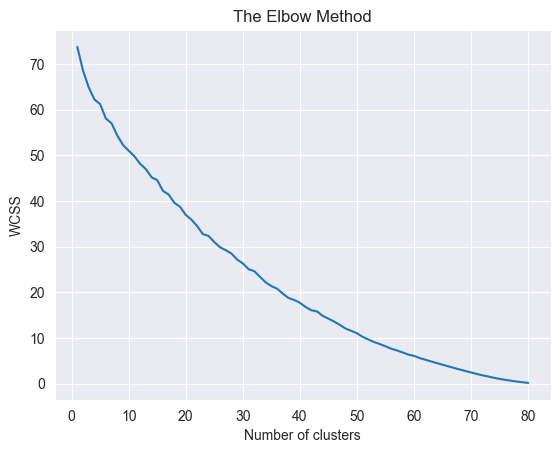

In [1056]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, MODULE_COUNT):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, MODULE_COUNT), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [1057]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=int(CLUSTER_COUNT), random_state=42)

kmeans.fit(X)

clusters = kmeans.labels_

In [1058]:
y_pred = kmeans.predict(X)

In [1059]:
print(silhouette_score(X, y_pred))

0.13435032506933828


In [1060]:
from sklearn.decomposition import PCA

pca = PCA(n_components=int(CLUSTER_COUNT), random_state=42)

reduced_features = pca.fit_transform(X.toarray())

x0 = reduced_features[:, 0]
x1 = reduced_features[:, 1]

In [1061]:
moduleDF['cluster'] = clusters
moduleDF['x0'] = x0
moduleDF['x1'] = x1

In [1062]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for k,r in df.iterrows():
        print('\nCluster {}'.format(k))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score

get_top_keywords(10)


Cluster 0
sensitivity,constraints,regression,optimal,programming,graphical,linear,algorithm,method,simplex

Cluster 1
applying,properties,states,probability,system,ergodic,absorbing,chain,chains,markov

Cluster 2
multicriteria,techniques,equations,profit,mixed,making,decision,programming,optimization,nonlinear

Cluster 3
able,constraints,solve,computer,modeling,graphical,models,model,linear,programming

Cluster 4
salesman,programming,tradeoffs,algorithms,travelling,euclidean,cost,distance,dynamic,shortest

Cluster 5
placement,locations,mathematical,cost,proximity,various,optimal,facilities,facility,location

Cluster 6
used,allocating,record,algorithms,programmingallocation,term,programming,allocation,dynamic,medical

Cluster 7
irregular,solutions,set,selection,optimization,covering,solve,algorithms,programming,integer

Cluster 8
arithmetic,optimization,video,research,analysis,data,logarithms,operations,models,breakeven

Cluster 9
linear,model,graphical,parameters,models,changes,statis

In [1063]:
cluster_map = {
    0: 'Introduction to Operations Research Model Formulation and Break-even Analysis',
    1: 'Linear Programming - Graphical Solution',
    2: 'Linear Programming Solutions and Sensitivity Analysis',
    3: 'Linear Programming - Modeling Examples',
    4: 'Linear Programming - Applications',
    5: "Integer Programming",
    6: "Integer Programs - Modeling Examples",
    7: "Transportation, Transshipment and Assignment Discussion",
    8: "Network Flow Models",
    9: "Multi - Criteria Decision Making: Goal Programming",
    10: "Goal Programming Discussion",
    11: "Non-Linear Programming",
    12: 'Non-Linear Programming Discussion',
    13: 'Applications of Markov Analysis'
}

moduleDF['cluster'] = moduleDF['cluster'].map(cluster_map)

In [1064]:
moduleDF.head(20)

,id,number,hours,feature,cleaned_feature,tokens,cluster,x0,x1
0,644827afc3faa4c9ea96a800,72,0.750,Linear Regression Linear Regression Correlatio...,linear regression linear regression correlatio...,linear regression linear regression correlatio...,Introduction to Operations Research Model Form...,0.043736,-0.156306
1,64496079d5fb014e40d5ea39,9,1.500,Statistical Analysis Statistical Analysis Desc...,statistical analysis statistical analysis desc...,statistical analysis statistical analysis desc...,Multi - Criteria Decision Making: Goal Program...,0.123050,-0.225736
2,644960add5fb014e40d5ea3a,121,2.000,Logarithms Logarithms Exponential Functions Lo...,logarithms logarithms exponential logarithmic ...,logarithms logarithms exponential logarithmic ...,Network Flow Models,0.093703,-0.141099
3,644960bcd5fb014e40d5ea3b,2,0.500,Arithmetics Arithmetic Operations Addition Sub...,arithmetics arithmetic operations addition sub...,arithmetics arithmetic operations addition sub...,Network Flow Models,0.080679,-0.164076
4,64496111d5fb014e40d5ea3c,887,2.250,Euclidean distance Euclidean Distance Distance...,euclidean distance euclidean distance distance...,euclidean distance euclidean distance distance...,Linear Programming - Applications,0.100747,-0.168584
5,64511f49f9ce74323575fffe,1,0.300,Introduction Linear Programming Modeling Compu...,introduction linear programming modeling compu...,introduction linear programming modeling compu...,Multi - Criteria Decision Making: Goal Program...,-0.036090,-0.179638
6,64511f4bf9ce74323575ffff,2,0.300,Computer Solutions for LP Formulations Linear ...,computer solutions formulations linear program...,computer solutions formulations linear program...,Introduction to Operations Research Model Form...,-0.137398,-0.066027
7,646270b939769687f2a6d858,1,0.300,Linear Programming - Modeling Example Linear P...,linear programming modeling linear programming...,linear programming modeling linear programming...,Linear Programming - Modeling Examples,-0.341487,0.212313
8,646273ce39769687f2a6d860,1,0.700,Transportation Example Transportation Example ...,transportation transportation transportation i...,transportation transportation transportation i...,Goal Programming Discussion,0.078740,-0.163413
9,646273e539769687f2a6d861,2,0.730,Transshipment Example Transshipment Example Tr...,transshipment transshipment transshipment intr...,transshipment transshipment transshipment intr...,Goal Programming Discussion,0.103499,-0.205058


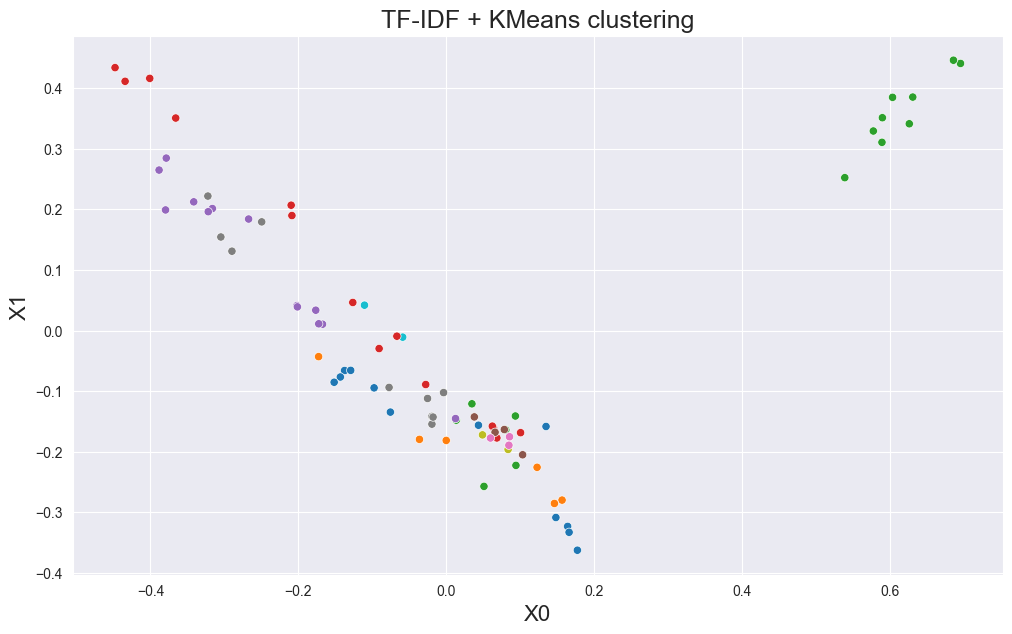

In [1065]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=moduleDF, x='x0', y='x1', hue='cluster', palette="tab10", legend=False)
plt.show()

In [1066]:
# sum the number of hours for each cluster
moduleDF.groupby('cluster')['hours'].sum().sort_values(ascending=False)

cluster
Linear Programming - Graphical Solution                                          10.812385
Transportation, Transshipment and Assignment Discussion                          10.672610
Linear Programming - Modeling Examples                                           10.627812
Introduction to Operations Research Model Formulation and Break-even Analysis     9.455611
Linear Programming Solutions and Sensitivity Analysis                             9.414316
Network Flow Models                                                               8.133975
Linear Programming - Applications                                                 6.749953
Multi - Criteria Decision Making: Goal Programming                                4.733289
Applications of Markov Analysis                                                   4.215039
Integer Programs - Modeling Examples                                              2.854403
Goal Programming Discussion                                                       

<AxesSubplot:title={'center':'ENMA 603 - Total Hours and Module count per Cluster'}, xlabel='Cluster', ylabel='Hours & Count'>

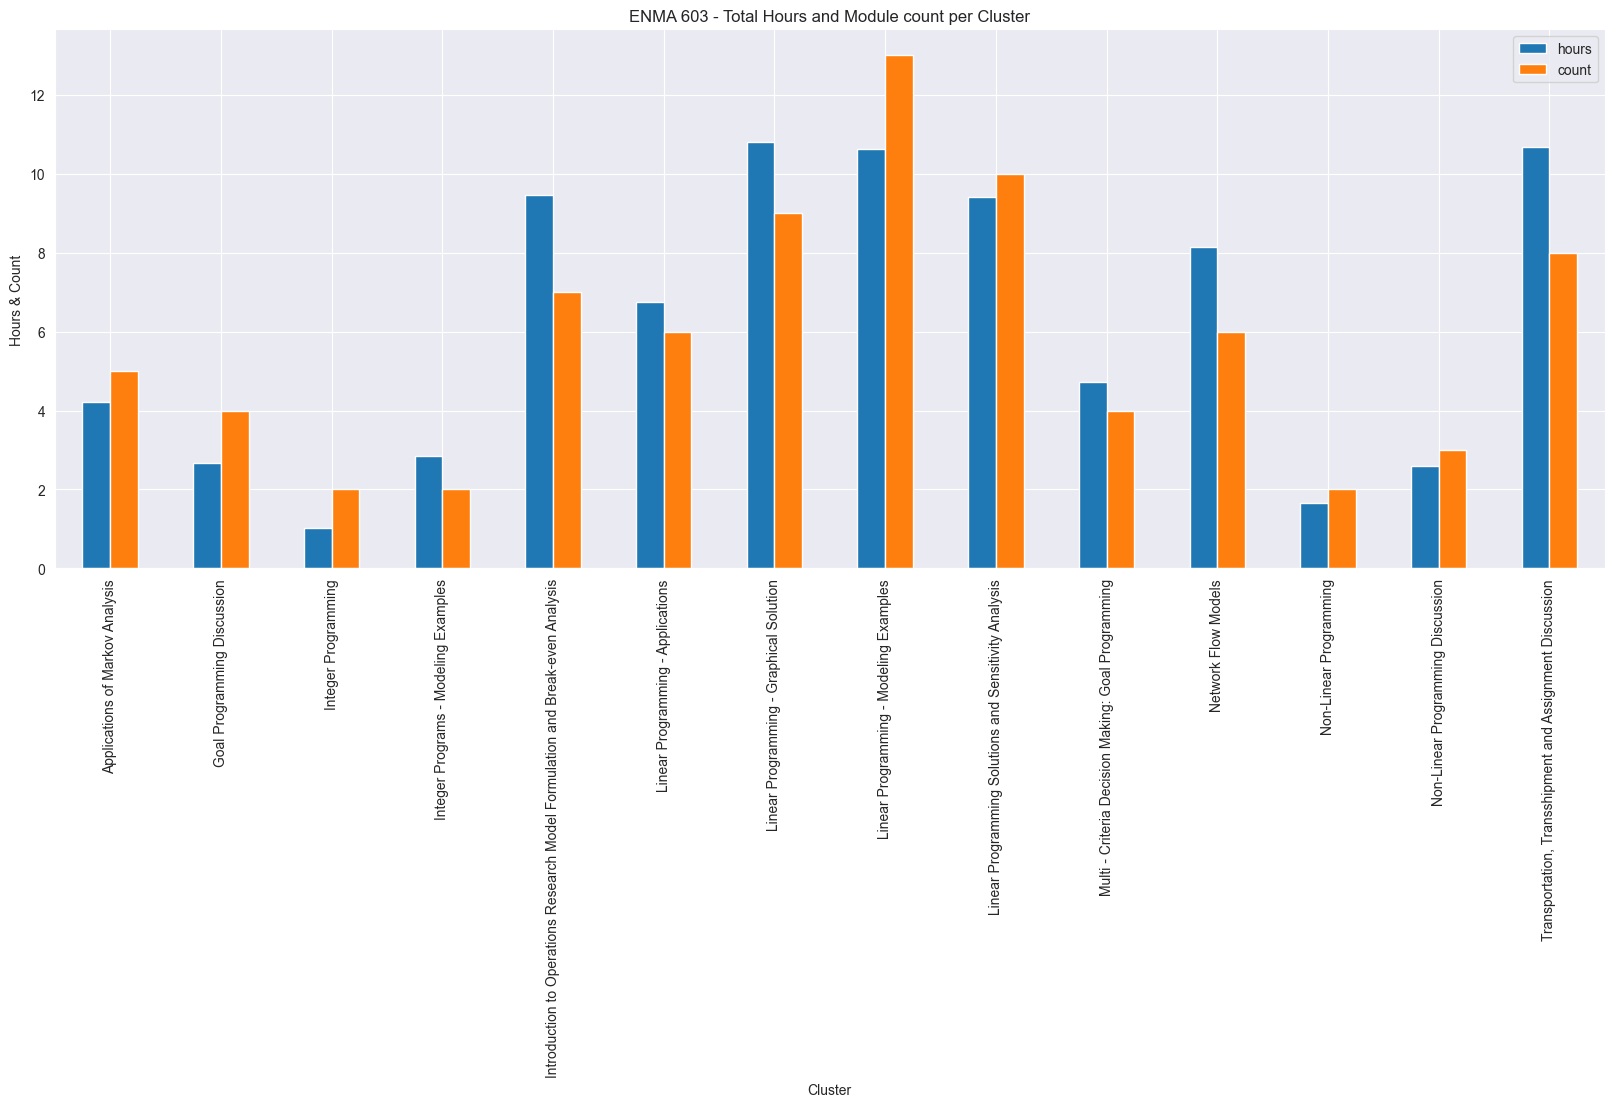

In [1067]:
pd.concat(
    [
        moduleDF.groupby('cluster')['hours'].sum().rename('hours'),
        moduleDF.groupby('cluster')['id'].count().rename('count')
    ],
    axis=1
).plot(kind='bar', figsize=(20, 7), title='ENMA 603 - Total Hours and Module count per Cluster', xlabel='Cluster', ylabel='Hours & Count', legend=['Hours', 'Count'])

In [1068]:
moduleDF.sort_values(by=['x0', 'x1'], ascending=False)

,id,number,hours,feature,cleaned_feature,tokens,cluster,x0,x1
26,64627a0e39769687f2a6d872,1,0.500000,Introduction to Markov Chains Markov Chains In...,introduction markov chains markov chains intro...,introduction markov chains markov chains intro...,Linear Programming - Graphical Solution,0.695954,0.440704
76,646506f68019c4d441f6ec38,1,1.957619,Introduction to Markov Chains Demonstrate unde...,introduction markov chains demonstrate concept...,introduction markov chains demonstrate concept...,Linear Programming - Graphical Solution,0.686397,0.446011
78,646506f78019c4d441f6ec3a,3,0.802423,Absorbing Markov Chains Demonstrate an underst...,absorbing markov chains demonstrate fundamenta...,absorbing markov chains demonstrate fundamenta...,Linear Programming - Graphical Solution,0.631354,0.385190
80,646506f78019c4d441f6ec3c,1,1.553647,Applying Markov Chains Demonstrate an understa...,applying markov chains demonstrate markov chai...,applying markov chains demonstrate markov chai...,Linear Programming - Graphical Solution,0.626662,0.341142
77,646506f78019c4d441f6ec39,2,1.694718,Ergodic Markov Chains Understand the fundament...,ergodic markov chains understand fundamentals ...,ergodic markov chains understand fundamentals ...,Linear Programming - Graphical Solution,0.604040,0.384776
...,...,...,...,...,...,...,...,...,...
43,646506f28019c4d441f6ec17,1,1.661044,Linear Programming Modeling Examples Understan...,linear programming modeling understand fundame...,linear programming modeling understand fundame...,Linear Programming - Modeling Examples,-0.379629,0.198947
66,646506f48019c4d441f6ec2e,2,1.034748,Goal Programming Computer Solution Understand ...,programming computer understand concept progra...,programming computer understand concept progra...,Linear Programming - Modeling Examples,-0.388386,0.264755
51,646506f38019c4d441f6ec1f,1,1.980177,Introduction to Integer Programming Understand...,introduction integer programming understand fu...,introduction integer programming understand fu...,"Transportation, Transshipment and Assignment D...",-0.401000,0.416064
52,646506f38019c4d441f6ec20,2,0.738020,Integer programming Examples Discuss the conce...,integer programming concepts techniques linear...,integer programming concepts techniques linear...,"Transportation, Transshipment and Assignment D...",-0.434353,0.411220


array([[<AxesSubplot:title={'center':'hours'}>]], dtype=object)

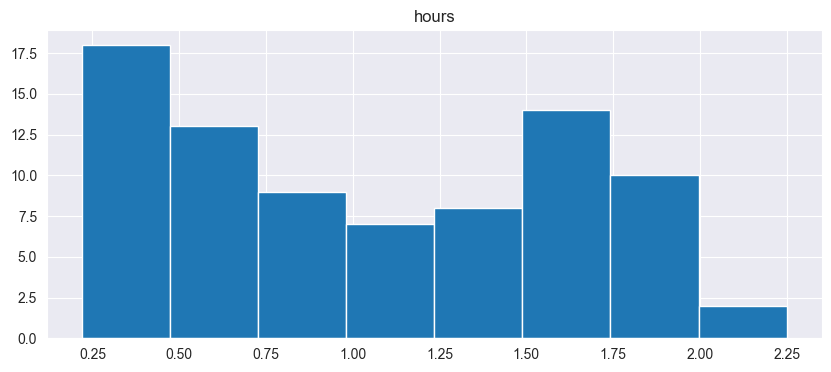

In [1069]:
moduleDF.hist(figsize=(10, 4), bins=8, column='hours')